In [85]:
# img_directory = '/home/ec2-user/img_align_celeba'
# img_directory = '/Users/rwilliams/Desktop/celeba/training'
img_directory = '/home/ec2-user/img_align_celeba'
# img_directory = '/home/ec2-user/autoencoder-vaegan/colbert'
model_save_path = '/home/ec2-user/vaegan-celeba.ckpt'
batch_size = 64
# training_set_size = 3326
training_set_size = 2048
img_size = 64
zsize = 128

In [2]:
import sys
sys.path.append('/home/ec2-user/autoencoder-vaegan')

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
from utils import imshow, resize_crop, load_img
%matplotlib inline

In [3]:
# load training data
training = np.array([resize_crop(load_img(i+1, img_directory), (img_size, img_size)) for i in range(training_set_size)])

/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


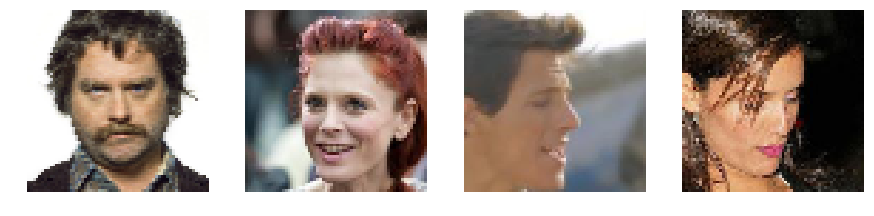

In [4]:
imshow([training[i] for i in range(4)])

# Build graph

In [52]:
# create models

import tensorflow as tf
from autoencoder import Autoencoder
from discriminator import Discriminator

tf.reset_default_graph()

# input images feed
X = tf.placeholder(tf.float32, [None, img_size, img_size, 3])

# for feeding random draws of z (latent variable)
Z = tf.placeholder(tf.float32, [None, zsize])

# encoder, decoder that will be connected to a discriminator
vae = Autoencoder(img_shape=(img_size, img_size, 3), zsize=zsize)
encoder = vae.encoder(X)
decoder = vae.decoder(encoder)

# a second decoder for decoding samplings of z
decoder_z_obj = Autoencoder(img_shape=(img_size, img_size, 3), zsize=zsize)
decoder_z = decoder_z_obj.decoder(Z, reuse=True)

# discriminator attached to vae output
disc_vae_obj = Discriminator(img_shape=(img_size, img_size, 3))
disc_vae_obj.disc(decoder)
disc_vae_logits = disc_vae_obj.logits

# discriminator attached to X input
# shares weights with other discriminator
disc_x_obj = Discriminator(img_shape=(img_size, img_size, 3))
disc_x_obj.disc(X, reuse=True)
disc_x_logits = disc_x_obj.logits

# discriminator attached to random Zs passed through decoder
# shares weights with other discriminator
disc_z_obj = Discriminator(img_shape=(img_size, img_size, 3))
disc_z_obj.disc(decoder_z, reuse=True)
disc_z_logits = disc_z_obj.logits

# Loss functions and optimizers

In [53]:
learning_rate = 0.00001

# set up loss functions and training_ops

# latent loss used for training encoder
latent_loss = vae.latent_loss()

# loss that uses decoder to determine similarity between
# actual input images and output images from the vae
similarity_xentropy = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=disc_x_obj.similarity, 
    logits=disc_vae_obj.similarity)
similarity_loss = tf.reduce_sum(similarity_xentropy)

# losses for the discriminator's output. Labes are real: 0, fake: 1.
# cross entropy with 1 labes, since training prob that image is fake
disc_vae_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.ones_like(disc_vae_logits),
    logits=disc_vae_logits))

# cross entropy with 0 labes, since training prob that image is fake
disc_x_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.zeros_like(disc_x_logits),
    logits=disc_x_logits))

# cross entropy with 1 labes, since training prob that image is fake
disc_z_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.ones_like(disc_z_logits),
    logits=disc_z_logits))

# minimize these with optimizer
disc_loss = disc_vae_loss + disc_x_loss + disc_z_loss
encoder_loss = latent_loss + similarity_loss
decoder_loss = similarity_loss - disc_loss

# get weights to train for each of encoder, decoder, etc.
# pass this to optimizer so it only trains w.r.t the network
# we want to train and just uses other parts of the network as is
# (for example use the discriminator to compute a loss during training
# of the encoder, but don't adjust weights of the discriminator)

encoder_vars = [i for i in tf.trainable_variables() if 'encoder' in i.name]
decoder_vars = [i for i in tf.trainable_variables() if 'decoder' in i.name]
disc_vars = [i for i in tf.trainable_variables() if 'discriminator' in i.name]

train_encoder = tf.train.AdamOptimizer(learning_rate=learning_rate) \
    .minimize(encoder_loss, var_list=encoder_vars)
    
train_decoder = tf.train.AdamOptimizer(learning_rate=learning_rate) \
    .minimize(decoder_loss, var_list=decoder_vars)
    
train_disc = tf.train.AdamOptimizer(learning_rate=learning_rate) \
    .minimize(disc_loss, var_list=disc_vars)

saver = tf.train.Saver()

# Init session

In [55]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
# saver.restore(sess, model_save_path)

# Train

In [94]:
import math
epochs = 100
batches = int(float(training_set_size) / batch_size)

saver.save(sess, model_save_path)

for epoch in range(epochs):
    print ('epoch %s ' % epoch, end='')
    zdraws = np.random.normal(size=(training_set_size, zsize))
    
    # train discriminator
    for batch in range(batches):
        xfeed = training[batch*batch_size:(batch+1)*batch_size]
        zfeed = zdraws[batch*batch_size:(batch+1)*batch_size]
        sess.run(train_disc, feed_dict={X: xfeed, Z: zfeed})
        print('.', end='')
         
    # train encoder
    for batch in range(batches):
        xfeed = training[batch*batch_size:(batch+1)*batch_size]
        sess.run(train_encoder, feed_dict={X: xfeed})
        print('.', end='')
        
    # train decoder
    for batch in range(batches):
        xfeed = training[batch*batch_size:(batch+1)*batch_size]
        zfeed = zdraws[batch*batch_size:(batch+1)*batch_size]
        sess.run(train_decoder, feed_dict={X: xfeed, Z: zfeed})
        print('.', end='')
        
    print('')
        
    #loss_out = train_disc_loss.eval(feed_dict={X: training[:64], Z: zdraws[:64]})
    #print(loss_out.shape)
    #print(loss_out)
 
#     if (epoch % 10 == 0):
#         print('saving session')
#         saver.save(sess, model_save_path)
    

epoch 0 ................................................................................................
epoch 1 ................................................................................................
epoch 2 ................................................................................................
epoch 3 ................................................................................................
epoch 4 ................................................................................................
epoch 5 ................................................................................................
epoch 6 ................................................................................................
epoch 7 ................................................................................................
epoch 8 ................................................................................................
epoch 9 ...............................................

KeyboardInterrupt: 

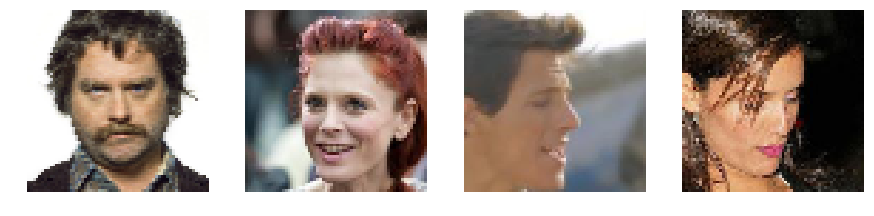

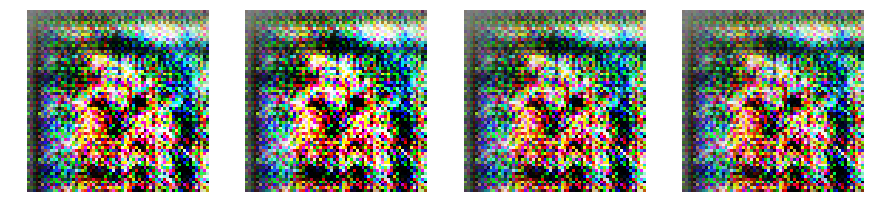

In [95]:
vae_out = decoder.eval(feed_dict={X: training[:4]})
imshow(training[:4])
imshow(vae_out[:4])

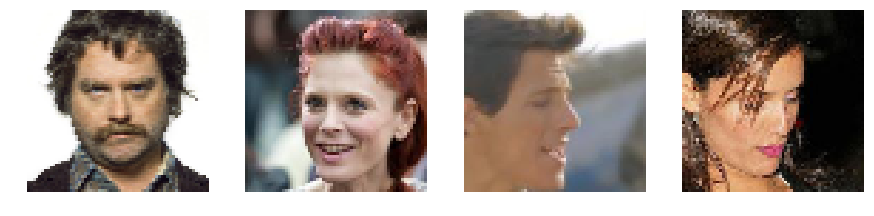

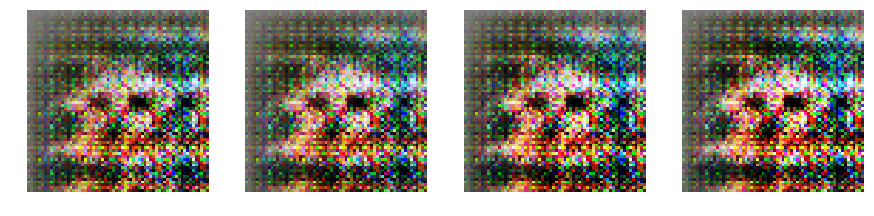

In [92]:
vae_out = decoder.eval(feed_dict={X: training[:4]})
imshow(training[:4])
imshow(vae_out[:4])

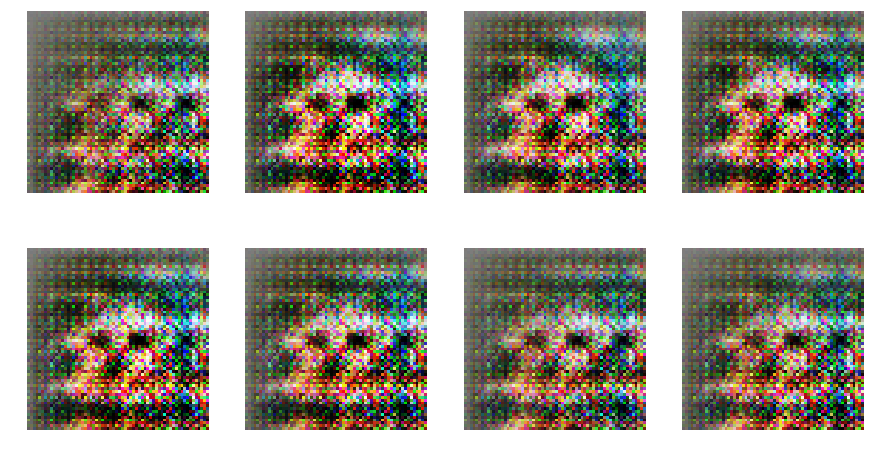

In [93]:
r = np.random.normal(size=(8,128), scale=1.0)
y = sess.run(decoder, feed_dict={encoder: r})
imshow(y[0:8])